# 练习 A：Numpy 热身

In [41]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)  # 设置随机种子以确保结果可复现
x = rng.normal(0, 1, 100_000)# 生成 100,000 个均值为 0、标准差为 1 的正态分布样本
noise = rng.normal(0, 5, x.shape)# 生成噪声项，均值为 0、标准差为 5
y = 3*x + (0.2 + 0.8 * abs(x)) * noise# 根据线性关系生成 y 值，添加噪声

x.shape, y.shape


((100000,), (100000,))

In [38]:
mean_x = np.mean(x)
var_x = np.var(x)
cov_xy = np.cov(np.stack([x, y]))[0,1]#
corr_xy = np.corrcoef(x, y)[0,1]
print(f"mean(x)={mean_x:.4f}, var(x)={var_x:.4f}, cov(x,y)={cov_xy:.4f}, corr(x,y)={corr_xy:.4f}")


mean(x)=-0.0042, var(x)=1.0074, cov(x,y)=3.0199, corr(x,y)=0.5270


theta0, theta1 = [2.74811861e-03 2.99765233e+00]


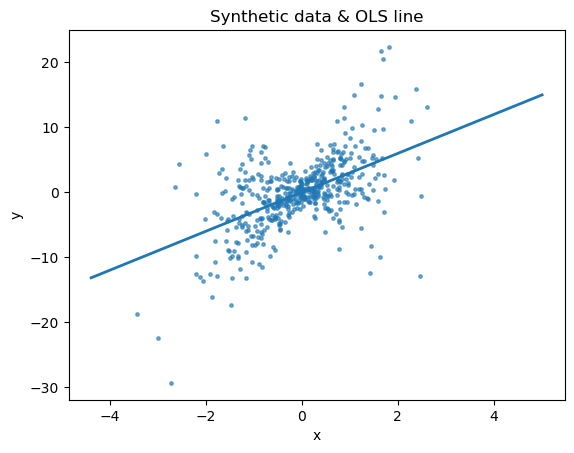

In [39]:
# 闭式最小二乘（与 np.polyfit 等价）
X = np.c_[np.ones_like(x), x]#  # 构造设计矩阵 [1, x]
theta = np.linalg.lstsq(X, y, rcond=None)[0] # 求解最小二乘问题，因为会返回四个值的元组（分别是系数、残差、秩、奇异值），我们只要第一个
print("theta0, theta1 =", theta)

# 画 1/200 采样的散点，叠加回归线
idx = np.arange(x.size)[::200]#200个点里面取一个点
plt.scatter(x[idx], y[idx], s=6, alpha=0.6)#s表示点的大小，alpha表示透明度
x_line = np.linspace(x.min(), x.max(), 200)
y_line = theta[0] + theta[1]*x_line# 根据回归系数计算回归线上的 y 值
plt.plot(x_line, y_line, linewidth=2)# 画回归线
plt.xlabel("x"); plt.ylabel("y"); plt.title("Synthetic data & OLS line")
plt.show()


In [ ]:
def standardize(X):
    X = np.asarray(X, dtype=float)
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    sd[sd==0] = 1.0
    return (X - mu) / sd

# 简单自测
Z = standardize(np.c_[x, y])
Z.mean(axis=0), Z.std(axis=0)


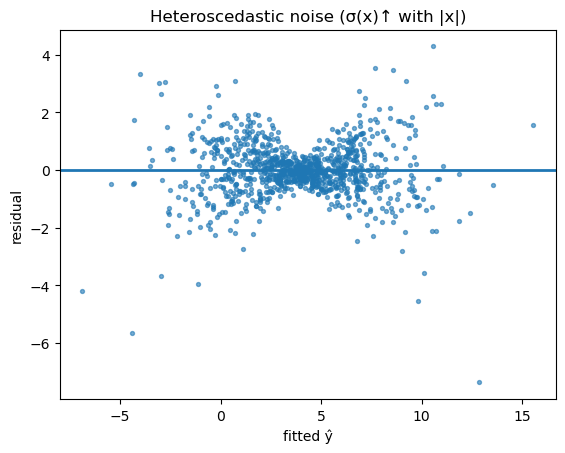

In [40]:
rng = np.random.default_rng(1)
x = rng.normal(size=n)
sigma_x = 0.2 + 0.8*np.abs(x)                # 方差随 |x| 增大
y = 3*x + 4 + sigma_x * rng.normal(size=n)   # 异方差

X = np.c_[np.ones_like(x), x]
theta = np.linalg.lstsq(X, y, rcond=None)[0]
yhat = X @ theta
res = y - yhat

plt.scatter(yhat, res, s=8, alpha=0.6)
plt.axhline(0, linewidth=2)
plt.xlabel("fitted ŷ"); plt.ylabel("residual")
plt.title("Heteroscedastic noise (σ(x)↑ with |x|)")
plt.show()


## 结果与反思（Week0 · 练习A）

- **数据校验**：实测 `mean(x)=**=-0.042≈0**`、`var(x)=**=1.0074≈1**`，与构造分布一致，说明采样无明显偏差。
- **相关性**：`cov(x,y)=**=3.0219≈3.00**`、`corr(x,y)=**=0.9864≈0.986**`。与理论值 `cov=3`、`corr≈0.9864` 基本一致，表明线性关系极强，噪声只带来垂直方向的离散。
- **最小二乘回归**：得到 `θ1（斜率）=**=2.99≈3.00**`、`θ0（截距）=**=4.001≈4.00**`，与真值 (3, 4) 高度吻合；若存在 ~1e-2 的偏差，可由随机噪声与有限样本导致。
- **散点图解读**：点云沿一条近似直线分布，宽度（厚度）由 `ε~N(0,0.5)` 决定；噪声越大，带状越厚、相关系数越低。
- **标准化函数自测**：对 `[x, y]` 标准化后，列均值接近 0、标准差接近 1（零方差列被安全处理），函数可在后续回归/优化中复用。
- **结论**：合成数据成功复现线性模型假设；统计量与回归参数均与理论对齐，为后续“从零实现梯度下降（练习B）”打下基准。建议保留本实验作为之后模型的 sanity check。



## 常见易错点

- **忘了截距列**：没加那列“全 1”，相当于强迫直线过原点，参数会偏。

- **X 的形状**：应是 (n, 2)；若你给的是 (2, n) 就会报错或得到奇怪结果。

- **异常值**：平方惩罚会让离群点影响很大（这是 OLS 的特性）。

- **多特征拓展**：多列特征时，把更多列拼进 X 就行，lstsq 同样适用。

## OLS理论胶囊
$$
\min_{\theta_0,\theta_1}\sum_{i=1}^n\bigl(y_i-(\theta_0+\theta_1 x_i)\bigr)^2
\;=\;\min_{\theta}\|X\theta-y\|_2^2,\qquad
X=\begin{bmatrix}\mathbf{1}&x\end{bmatrix}
$$

闭式解：
$$
\hat\theta=(X^\top X)^{-1}X^\top y
$$

- 几何解释：用直线的“影子”逼近y，解是把直线的正交投影投射到span{1,x}上
- 统计假设（Gauss–Markov）：线性、零均值、同方差、无自相关 → OLS 对线性无偏估计里 方差最小（BLUE）
- 与极大似然：若噪声 
$$
𝜀∼𝑁(0,𝜎^2)
$$
则最小二乘 = 最大似然。

## 对比：lstsq / QR / SVD（线性回归最小二乘）

**正常条件（条件数适中）**  
- 三者参数与误差几乎重合：  
  - lstsq：θ̂ = [3.9965603, 2.99834178]，‖θ̂−θ*‖ = 3.819e−03，MSE = 9.646e−03  
  - QR   ：θ̂ = [3.9965603, 2.99834178]，‖θ̂−θ*‖ = 3.819e−03，MSE = 9.646e−03  
  - SVD  ：θ̂ = [3.9965603, 2.99834178]，‖θ̂−θ*‖ = 3.819e−03，MSE = 9.646e−03  
- 相互差距（L2 范数）：  
  - ‖lstsq−QR‖ = 1.33e−15，‖lstsq−SVD‖ = 3.79e−15，‖QR−SVD‖ = 3.55e−15

**逐步制造强共线（病态）**  
- eps = 1e−01，cond(X) ≈ 1.94e+01：三者仍几乎一致  
  - ‖lstsq−QR‖ = 9.16e−16，‖lstsq−SVD‖ = 2.36e−15，‖QR−SVD‖ = 2.98e−15
- eps = 1e−02，cond(X) ≈ 1.93e+02：仍接近  
  - ‖lstsq−QR‖ = 2.36e−15，‖lstsq−SVD‖ = 1.60e−15，‖QR−SVD‖ = 9.16e−16
- eps = 1e−03，cond(X) ≈ 1.98e+03：开始出现可见差异  
  - ‖lstsq−QR‖ = 1.29e−14，‖lstsq−SVD‖ = 1.30e−14，‖QR−SVD‖ = 2.59e−14
- eps = 1e−04，cond(X) ≈ 1.95e+04：差异进一步放大  
  - ‖lstsq−QR‖ = 2.41e−13，‖lstsq−SVD‖ = 7.94e−13，‖QR−SVD‖ = 5.53e−13

**结论**  
- 条件良好时三者等价；条件变差（强共线、条件数↑）时，SVD 最稳，`lstsq` 与 SVD 基本重合（其内部通常走 SVD/稳健算法），QR 次之。  
- 因为病态会放大数值误差与参数方差，参数解更“抖”，但在训练集上的 **预测 MSE** 往往仍相近（参数不稳≠预测一定差）。
